In [ ]:
#73c9a156b91f3e0c01c3d5f332d23bfc66f4cdbf

In [1]:
import wandb
wandb.init(project="DQN", entity = "rl_proj")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/codespace/.netrc


In [1]:
import gym
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import namedtuple, deque
import time
from ale_py import ALEInterface
import imageio
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from utils_DQN import *
import os

In [ ]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

ale = ALEInterface()

np.random.seed(42)
tf.random.set_seed(42)


config= Config()
best_reward = 0

env = gym.make("Assault-v4") 
n_actions = env.action_space.n

# Creación del modelo y la memoria
model = DQN(n_actions)
model_target = DQN(n_actions)
memory = ReplayMemory(10000)

# Preparación del optimizador y la función de pérdida
optimizer = keras.optimizers.Adam(learning_rate=2.5e-4, clipnorm=1.0)
loss_function = keras.losses.Huber()

episode_rewards = []
losses = []

best_reward = float("-inf")
best_episode = 0
best_frames = []

# Entrenamiento del agente
epsilon = config.EPSILON_START
for episode in range(config.EPISODES):
    #reset_result = env.reset()
    #state = reset_result[0] / 255.0
    #info = reset_result[1]

    state = env.reset() / 255.0
    done = False
    episode_reward = 0
    steps = 0
    info ={'ale.lives': 4, 'episode_frame_number': 2, 'frame_number': 2}
    frames = []
    current_frames = []  
    episode_reward = 0

    while not done and info.get("ale.lives") >= 0:
        action = take_action(state, epsilon, env, model)

        step_result = env.step(action)
        next_state, reward, done, info = step_result
        next_state = next_state / 255.0

        memory.push(state, action, next_state, reward, done)
        optimize_model(memory, config, model , model_target, n_actions , loss_function, optimizer)

        frame = env.render(mode='rgb_array')
        frames.append(frame)

        state = next_state
        episode_reward += reward

        if reward != 0:
            print("step: ", steps, "action: ", action, " reward: ", reward)
            print("Lives: ", info.get("ale.lives"))

        steps += 1
        
        
        
    print(f"\nEpisodio: {episode+1}, Recompensa: {episode_reward}, Epsilon: {epsilon}")
    
    if episode_reward > best_reward:
        best_reward = episode_reward

        #CAMBIAR PATH a DQN
        model.save("./best_DQN_model", save_format="tf")
        #CAMBIAR PATH
        model_target.save("./best_DQN_model_target", save_format="tf")
        print("New best model saved with reward:", episode_reward)

        gif_path = f"./episode_{episode+1}_reward_{episode_reward}.gif"
        imageio.mimsave(gif_path, frames, fps=30)        
    
    episode_rewards.append(episode_reward)
    
    epsilon = max((epsilon * config.EPSILON_DECAY_RATE), config.EPSILON_END)
    
    wandb.log({"episode": episode + 1, "reward": episode_reward, "epsilon": epsilon})
    
    
    if (episode + 1) % config.TARGET_UPDATE == 0:
        model_target.set_weights(model.get_weights())


env.close()


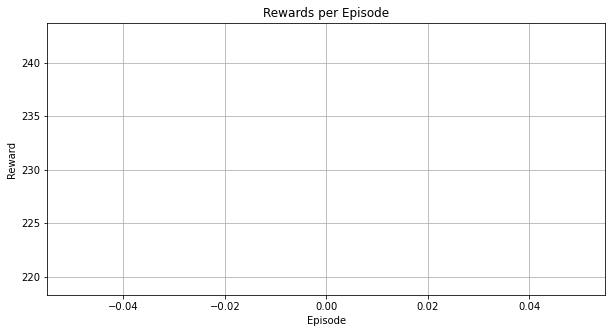

In [7]:
plot_rewards(episode_rewards)


In [ ]:
#TEST THE SAVED MODEL
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

#CAMBIAR PATH a DQN
DQN_model = keras.models.load_model(f"./best_DQN_model")
#CAMBIAR PATH a DQN
DQN_model_target = keras.models.load_model(f"./best_DQN_model_target")

env = gym.make("Assault-v4")
n_actions = env.action_space.n


rewards_per_episode = []
best_reward = 0

for episode in range(500):
    state= env.reset()
    state = state / 255.0  
    done = False
    episode_reward = 0
    frames = []
    info ={'ale.lives': 4, 'episode_frame_number': 2, 'frame_number': 2}

    while not done:
        action = take_action_test(state, model)
        next_state, reward, done, info = env.step(action)
        next_state = next_state / 255.0  

        frame = env.render(mode='rgb_array')
        frames.append(frame)

        state = next_state
        episode_reward += reward

        if reward != 0:
            print("action: ", action, " reward: ", reward)
            print("Lives: ", info.get("ale.lives"))
        
        #steps += 1

    rewards_per_episode.append(episode_reward)
    print(f"Episode {episode + 1}: Reward = {episode_reward}")

    if episode_reward > best_reward:
        best_reward = episode_reward  
        
        gif_path = f"./test_episode_{episode+1}_reward_{episode_reward}.gif"
        imageio.mimsave(gif_path, frames, fps=30)

    # Log episode metrics and GIF to wandb
    wandb.log({"episode": episode + 1, "reward": episode_reward, "epsilon": epsilon, "episode_gif": wandb.Video(gif_path, fps=4, format="gif")})


env.close()

# Grafica las recompensas por episodio
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.show()